# Photonics Transient

In [1]:
import jax
import jax.numpy as jnp

from circulus.compiler import compile_netlist
from circulus.solvers.strategies import DenseSolver
import matplotlib.pyplot as plt
import diffrax
from circulus.components import Resistor
from circulus.photonic_components import OpticalWaveguide, OpticalSourcePulse
from circulus.solvers.transient import VectorizedTransientSolver

--- DEMO: Photonic Transient (Flat Vector Fix) ---
1. Compiling...
2. Solving DC Operating Point...
   DC Converged. Norm: 2.05e-01
3. Running Transient Simulation...
   ✅ Simulation Successful


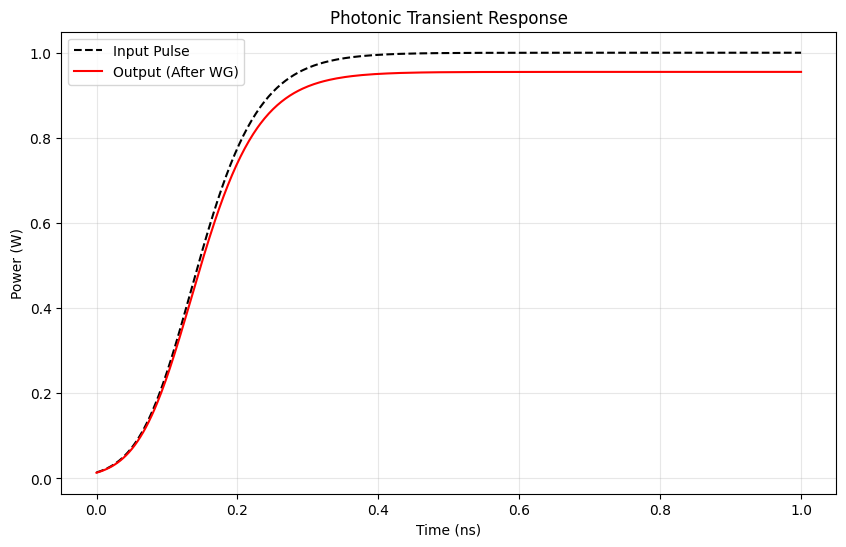

In [2]:
print("--- DEMO: Photonic Transient (Flat Vector Fix) ---")

jax.config.update ("jax_enable_x64", True)

models_map = {
    'waveguide': OpticalWaveguide,
    'source': OpticalSourcePulse,
    'resistor': Resistor,
    'ground': lambda: 0
}

net_dict = {
    "instances": {
        "GND": {"component": "ground"},
        "I1": {"component": "source", "settings": {"power": 1.0, "delay": 0.1e-9}},
        "WG1": {"component": "waveguide", "settings": {"length_um": 100.0, "loss_dB_cm": 20.0}},
        "R1": {"component": "resistor", "settings": {"R": 1.0}}
    },
    "connections": {
        "GND,p1": ("I1,p2", "R1,p2"),
        "I1,p1": "WG1,p1",
        "WG1,p2": "R1,p1"
    }
}

print("1. Compiling...")
groups, sys_size, port_map = compile_netlist(net_dict, models_map)

linear_strat = DenseSolver.from_circuit(groups, sys_size, is_complex=True)

print("2. Solving DC Operating Point...")

y_guess_flat = jnp.zeros(sys_size * 2, dtype=jnp.float64)
y_op_flat = linear_strat.solve_dc(groups, y_guess_flat)

print(f"   DC Converged. Norm: {jnp.linalg.norm(y_op_flat):.2e}")

solver = VectorizedTransientSolver(linear_solver=linear_strat)
term = diffrax.ODETerm(lambda t, y, args: jnp.zeros_like(y))

t_max = 1.0e-9
saveat = diffrax.SaveAt(ts=jnp.linspace(0, t_max, 500))

print("3. Running Transient Simulation...")
sol = diffrax.diffeqsolve(
    terms=term,
    solver=solver,
    t0=0.0,
    t1=t_max,
    dt0=1e-13,
    y0=y_op_flat,
    args=(groups, sys_size),
    saveat=saveat,
    max_steps=100000,
    throw=False,
    stepsize_controller=diffrax.PIDController(rtol=1e-4, atol=1e-6)
)

if sol.result == diffrax.RESULTS.successful:
    print("   ✅ Simulation Successful")
    
    ts = sol.ts * 1e9
    
    ys_flat = sol.ys
    ys_complex = ys_flat[:, :sys_size] + 1j * ys_flat[:, sys_size:]
    
    node_in_idx  = port_map["I1,p1"]
    node_out_idx = port_map["R1,p1"]

    v_in = ys_complex[:, node_in_idx]
    v_out = ys_complex[:, node_out_idx]
    
    plt.figure(figsize=(10, 6))
    plt.plot(ts, jnp.abs(v_in)**2, 'k--', label='Input Pulse')
    plt.plot(ts, jnp.abs(v_out)**2, 'r-', label='Output (After WG)')
    
    plt.title("Photonic Transient Response")
    plt.xlabel("Time (ns)")
    plt.ylabel("Power (W)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print(f"❌ Simulation Failed: {sol.result}")